# Data transformation

Add intro about this notebook.

## Imports

In [1]:
import os
from typing import Tuple

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, normalize

from src.utils.const import DATA_DIR, FIGURE_DIR, NUM_BINS, SEED
from src.utils.util_models import fix_random
from src.visualization.visualize import kdeplot
from src.visualization.visualize import barplot_multiple_columns
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn import ensemble, tree, svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score

### Useful path to data

In [2]:
ROOT_DIR = os.path.join(os.getcwd(), '..')
PROCESSED_DIR = os.path.join(ROOT_DIR, DATA_DIR, 'processed')
PLOT_DIR = os.path.join(ROOT_DIR, FIGURE_DIR)

In [3]:
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

### Fix random seed

In [4]:
fix_random(SEED)

## Read final dataset

In [5]:
final = pd.read_parquet(
    os.path.join(PROCESSED_DIR, 'final.parquet')
)

### Discretize target feature

Since we have that the `rating_mean` stays in a continues range between [0.5-5]. We decided to discretize into 10 bins of equal length where every one has a range of 0.45.

In [6]:
final = final.assign(rating_discrete=pd.cut(final.loc[:, 'rating_mean'], bins=NUM_BINS, labels=False))

### Separate train/test/val

In order to try different strategies of normalization and standardization, we need to split the dataset into train, test and validate set. As always suggested, we use the 20% of the dataset for the test and the 10% of the training set, for the validation.

In [7]:
data = final.loc[:, final.columns != 'rating_discrete']
target = final['rating_discrete']
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.2, stratify=target)
train_data, val_data, train_target, val_target = train_test_split(train_data, train_target, test_size=0.1,
                                                                  stratify=train_target)

## Min-max scaling/standardization evaluation

We first define a function that allows to apply the min-max scaling transformation on the whole dataset.

In [8]:
def min_max_scaling(train_x, val_x, test_x, cols):
    train_x_scale = train_x.copy()
    val_x_scale = val_x.copy()
    test_x_scale = test_x.copy()
    scaler = MinMaxScaler()
    for features in cols:
        feature_train = train_x_scale[features].to_numpy().reshape(-1, 1)
        feature_val = val_x_scale[features].to_numpy().reshape(-1, 1)
        feature_test = test_x_scale[features].to_numpy().reshape(-1, 1)

        scaled_train = np.squeeze(scaler.fit_transform(feature_train))
        scaled_val = np.squeeze(scaler.transform(feature_val))
        scaled_test = np.squeeze(scaler.transform(feature_test))

        train_x_scale[features] = scaled_train
        val_x_scale[features] = scaled_val
        test_x_scale[features] = scaled_test

    return train_x_scale, val_x_scale, test_x_scale

As we have seen during the lectures, we have to see the distribution of each variable, in order to decide which is the most suitable method.

#### title_length

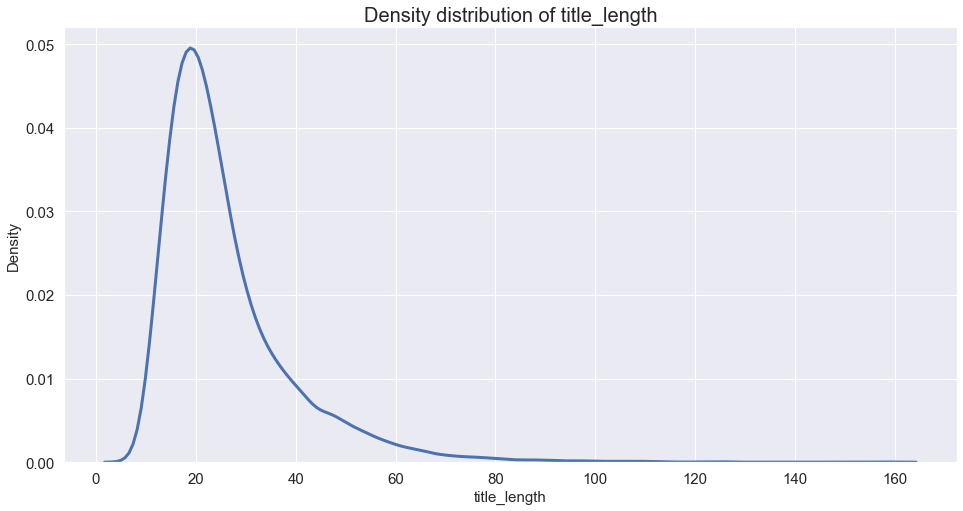

In [9]:
kdeplot(train_data['title_length'],
        title='Density distribution of title_length',
        xlabel='title_length',
        ylabel='Density',
        filename=os.path.join(PLOT_DIR, 'original_title_len.png'))

The distribution is not gaussian therefore we end up to apply min-max scaling in order to scale values in the range [0,1].

In [10]:
train_data_minmax, val_data_minmax, test_data_minmax = min_max_scaling(train_data, val_data, test_data,
                                                                       ['title_length'])

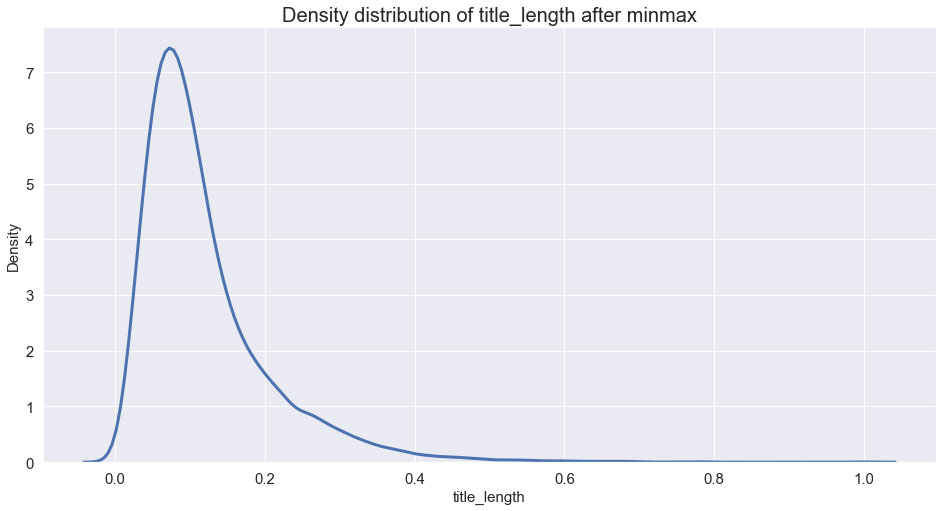

In [11]:
kdeplot(train_data_minmax['title_length'],
        title='Density distribution of title_length after minmax',
        xlabel='title_length',
        ylabel='Density',
        filename=os.path.join(PLOT_DIR, 'minmax_title_len.png'))

#### runtime

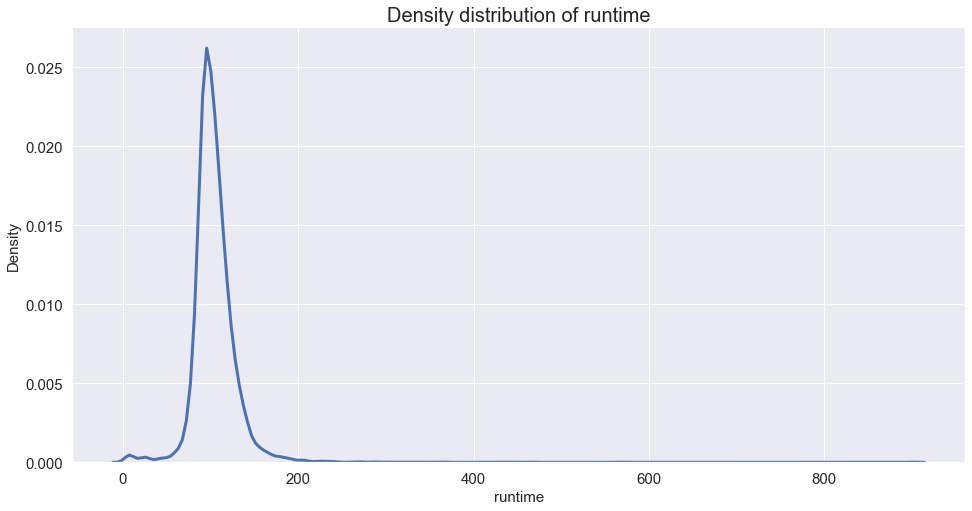

In [12]:
kdeplot(train_data['runtime'],
        title='Density distribution of runtime',
        xlabel='runtime',
        ylabel='Density',
        filename=os.path.join(PLOT_DIR, 'original_runtime.png'))

In [13]:
feature = ['title_length', 'runtime']

In [14]:
train_data_minmax, val_data_minmax, test_data_minmax = min_max_scaling(train_data, val_data, test_data,
                                                                       feature)

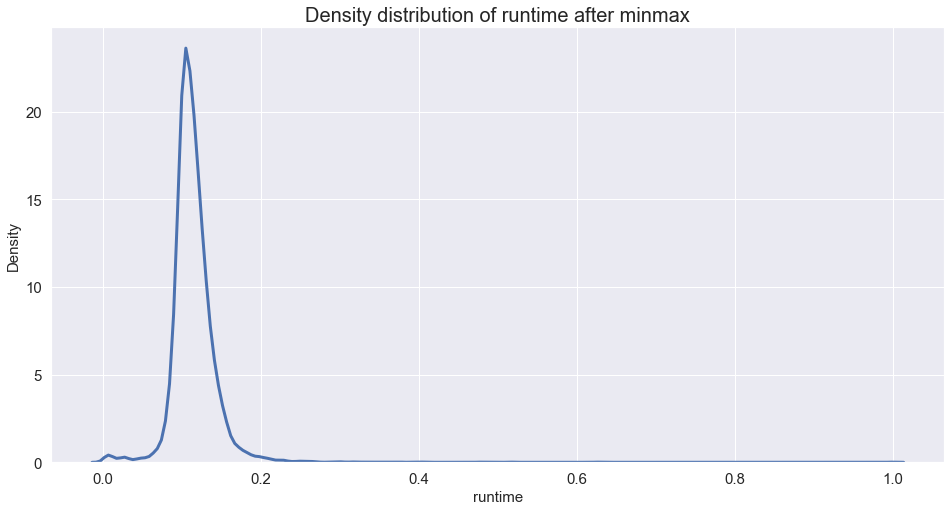

In [15]:
kdeplot(train_data_minmax['runtime'],
        title='Density distribution of runtime after minmax',
        xlabel='runtime',
        ylabel='Density',
        filename=os.path.join(PLOT_DIR, 'minmax_runtime.png'))

#### rating_count

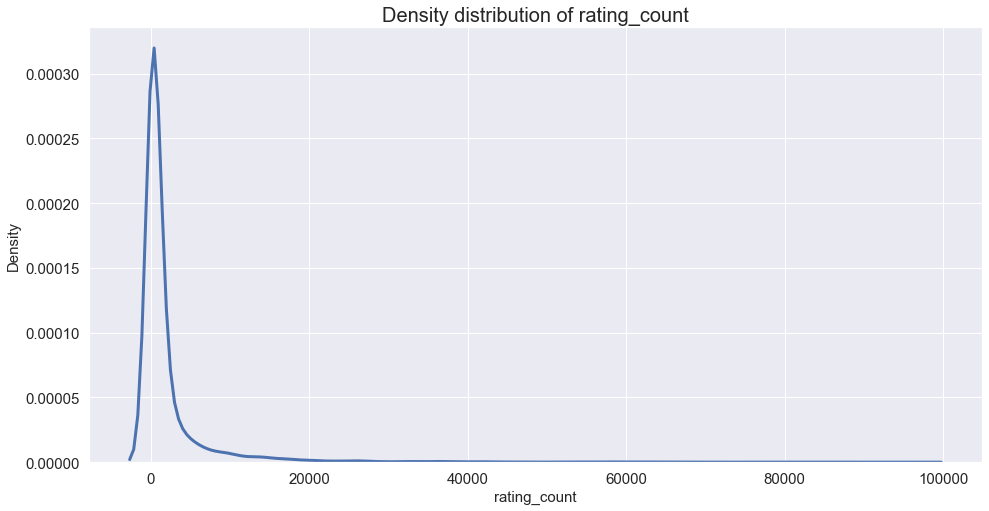

In [16]:
kdeplot(train_data['rating_count'],
        title='Density distribution of rating_count',
        xlabel='rating_count',
        ylabel='Density',
        filename=os.path.join(PLOT_DIR, 'original_rating_count.png'))

In [17]:
feature = ['title_length', 'runtime', 'rating_count']

In [18]:
train_data_minmax, val_data_minmax, test_data_minmax = min_max_scaling(train_data, val_data, test_data,
                                                                       feature)

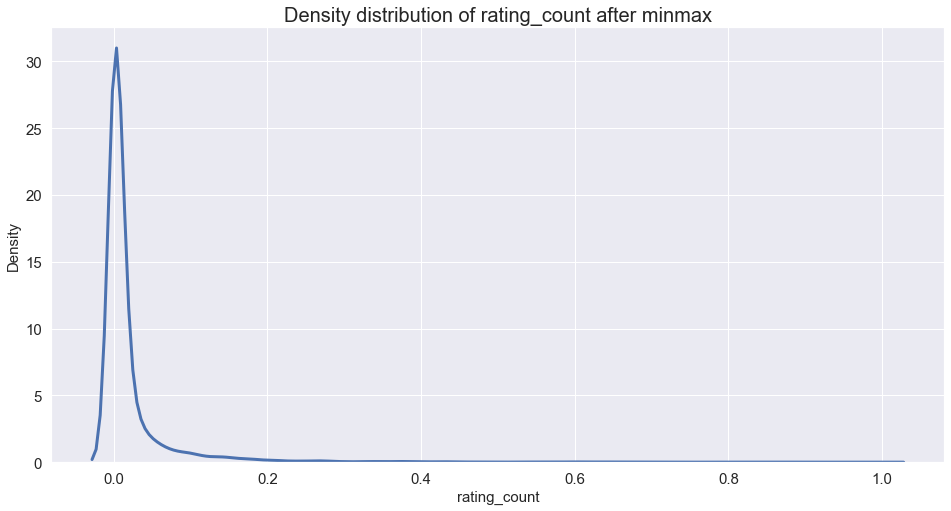

In [19]:
kdeplot(train_data_minmax['rating_count'],
        title='Density distribution of rating_count after minmax',
        xlabel='rating_count',
        ylabel='Density',
        filename=os.path.join(PLOT_DIR, 'minmax_rating_count.png'))

#### tag_count

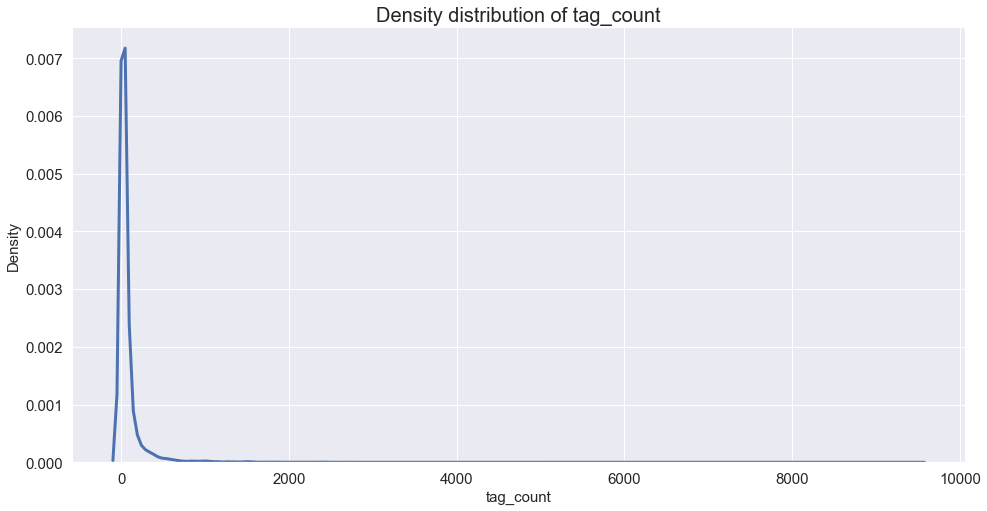

In [20]:
kdeplot(train_data['tag_count'],
        title='Density distribution of tag_count',
        xlabel='tag_count',
        ylabel='Density',
        filename=os.path.join(PLOT_DIR, 'original_tag_count.png'))

In [21]:
feature = ['title_length', 'runtime', 'rating_count', 'tag_count']

In [22]:
train_data_minmax, val_data_minmax, test_data_minmax = min_max_scaling(train_data, val_data, test_data,
                                                                       feature)

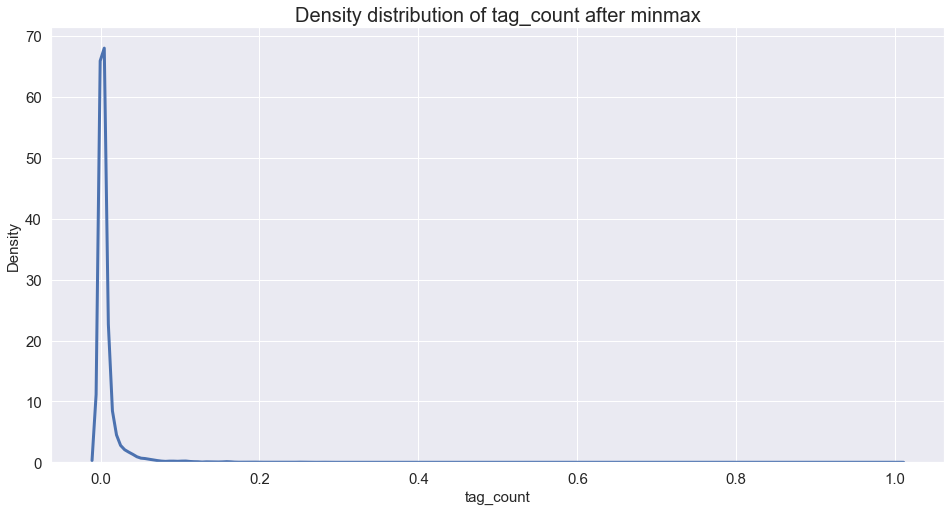

In [23]:
kdeplot(train_data_minmax['tag_count'],
        title='Density distribution of tag_count after minmax',
        xlabel='tag_count',
        ylabel='Density',
        filename=os.path.join(PLOT_DIR, 'minmax_tag_count.png'))

#### year

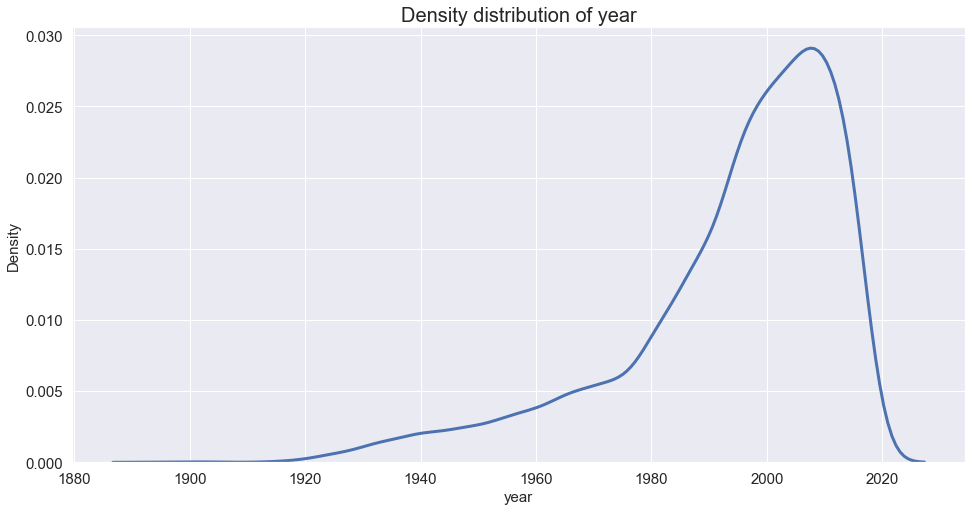

In [24]:
kdeplot(train_data['year'],
        title='Density distribution of year',
        xlabel='year',
        ylabel='Density',
        filename=os.path.join(PLOT_DIR, 'original_year.png'))

In [25]:
feature = ['title_length', 'runtime', 'rating_count', 'tag_count', 'year']

In [26]:
train_data_minmax, val_data_minmax, test_data_minmax = min_max_scaling(train_data, val_data, test_data,
                                                                       feature)

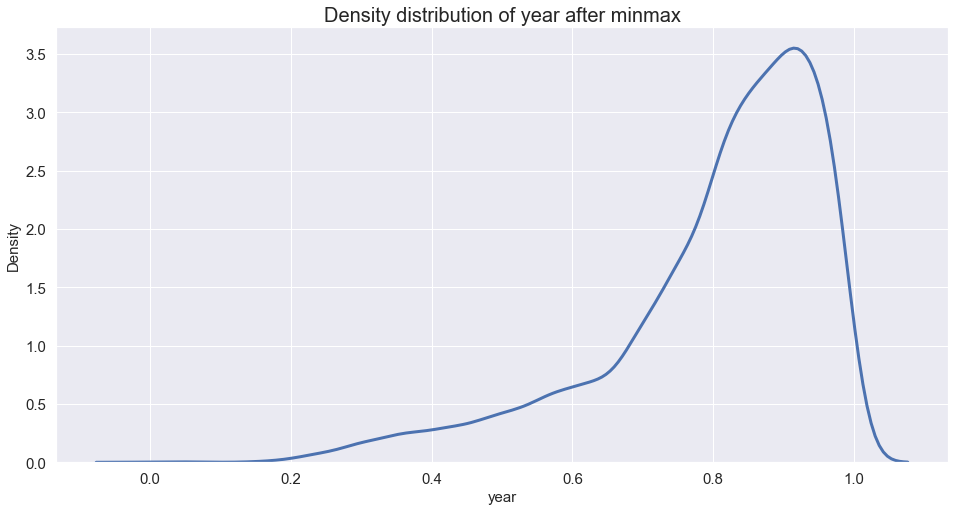

In [27]:
kdeplot(train_data_minmax['year'],
        title='Density distribution of year after minmax',
        xlabel='year',
        ylabel='Density', filename=os.path.join(PLOT_DIR, 'minmax_year.png'))

## Normalization

In [28]:
def normalization_categorical(train_x, val_x, test_x, ord) -> Tuple:
    x_train_normalized = train_x.copy()
    x_val_normalized = val_x.copy()
    x_test_normalized = test_x.copy()

    no_cat_columns = list(set(range(train_x.shape[1])) - set(range(2, 21)))

    cat_train_data = x_train_normalized.iloc[:, list(range(2, 21))]
    cat_test_data = x_test_normalized.iloc[:, list(range(2, 21))]
    cat_val_data = x_val_normalized.iloc[:, list(range(2, 21))]
    no_cat_train_data = x_train_normalized.iloc[:, no_cat_columns]
    no_cat_test_data = x_test_normalized.iloc[:, no_cat_columns]
    no_cat_val_data = x_val_normalized.iloc[:, no_cat_columns]

    norm_train = normalize(no_cat_train_data, norm=ord)
    norm_test = normalize(no_cat_test_data, norm=ord)
    norm_val = normalize(no_cat_val_data, norm=ord)

    all_train = np.concatenate((norm_train, cat_train_data), axis=1)
    all_test = np.concatenate((norm_test, cat_test_data), axis=1)
    all_val = np.concatenate((norm_val, cat_val_data), axis=1)

    return all_train, all_val, all_test

In [29]:
x_train_norm_cat, x_val_norm_cat, x_test_norm_cat = normalization_categorical(train_data_minmax, val_data_minmax,
                                                                              test_data_minmax, 'l2')

### normalization without minmax scaling

In [30]:
x_train_norm_no_minmax, x_val_norm_no_minmax, x_test_norm_no_minmax = normalization_categorical(train_data, val_data,
                                                                              test_data, 'l2')

## Evaluating Transformation

In [31]:
df = pd.DataFrame({})

In [32]:
models = {'random_forest': ensemble.RandomForestClassifier(),
          'decision_tree': tree.DecisionTreeClassifier(),
          'GaussianNB': GaussianNB(),
          'quadratic_discriminant': QuadraticDiscriminantAnalysis(store_covariance=True),
          'svm': svm.SVC()
          }

In [33]:
def try_sample(train_data_inside, train_target_inside, test_data_inside, test_target_inside, transformation: str) -> None:
    # Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
    global df
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)
    # Evaluate model
    scoring = ['f1_weighted']

    for elm in models.items():
        scores = cross_validate(elm[1], train_data_inside, train_target_inside, scoring=scoring, cv=cv, n_jobs=-1,
                                return_estimator=True)

        #gathering best estimator from cross validation
        best_estimator_index=np.argmax(scores['test_f1_weighted'])
        estimator=scores['estimator'][best_estimator_index]

        # testing the estimator
        y_pred=estimator.predict(test_data_inside)
        f1_test = f1_score(test_target_inside, y_pred, average='weighted')


        # summarize performance
        elemento = pd.DataFrame(
            {'transformation': [transformation], 'model_name': [elm[0]], 'mean_f1_val':[np.mean(scores['test_f1_weighted'])],
             'f1_score_test': [f1_test]})
        df = pd.concat([df, elemento])

    print(df[df['transformation'] == transformation])

## Testing all the models on the different transformed datasets

### Normalization and Minmax scaling

In [34]:
try_sample(train_data_inside=x_train_norm_cat, train_target_inside=train_target, test_data_inside=x_test_norm_cat, test_target_inside=test_target, transformation='Normalization - Minmax scaling')

                   transformation              model_name  mean_f1_val  \
0  Normalization - Minmax scaling           random_forest     0.738698   
0  Normalization - Minmax scaling           decision_tree     0.633700   
0  Normalization - Minmax scaling              GaussianNB     0.386155   
0  Normalization - Minmax scaling  quadratic_discriminant     0.286443   
0  Normalization - Minmax scaling                     svm     0.626589   

   f1_score_test  
0       0.730900  
0       0.633448  
0       0.379681  
0       0.296094  
0       0.620314  


### Minmax scaling

In [35]:
try_sample(train_data_inside=train_data_minmax, train_target_inside=train_target, test_data_inside=test_data_minmax, test_target_inside=test_target, transformation='Minmax scaling')

   transformation              model_name  mean_f1_val  f1_score_test
0  Minmax scaling           random_forest     0.860967       0.871673
0  Minmax scaling           decision_tree     0.999026       0.999299
0  Minmax scaling              GaussianNB     0.444394       0.451531
0  Minmax scaling  quadratic_discriminant     0.257001       0.260388
0  Minmax scaling                     svm     0.826898       0.821212


### Normalization

In [36]:
try_sample(train_data_inside=train_data_minmax, train_target_inside=train_target, test_data_inside=test_data_minmax,
           test_target_inside=test_target, transformation='Normalization')

  transformation              model_name  mean_f1_val  f1_score_test
0  Normalization           random_forest     0.859771       0.870907
0  Normalization           decision_tree     0.998790       0.999666
0  Normalization              GaussianNB     0.450294       0.448882
0  Normalization  quadratic_discriminant     0.257673       0.261484
0  Normalization                     svm     0.828149       0.825843


## Data visualization

### Preparing datas to be plotted

It is necessary to prepare the datas as follow:
- for each row it must contains the values of each group, since we have 5 groups it must contains 5 elements
- the number of rows must be equal to the number of columns of each group

In [37]:
data=[]
for elm in df['transformation'].unique():
    data.append(df[df['transformation']==elm]['f1_score_test'].to_numpy())

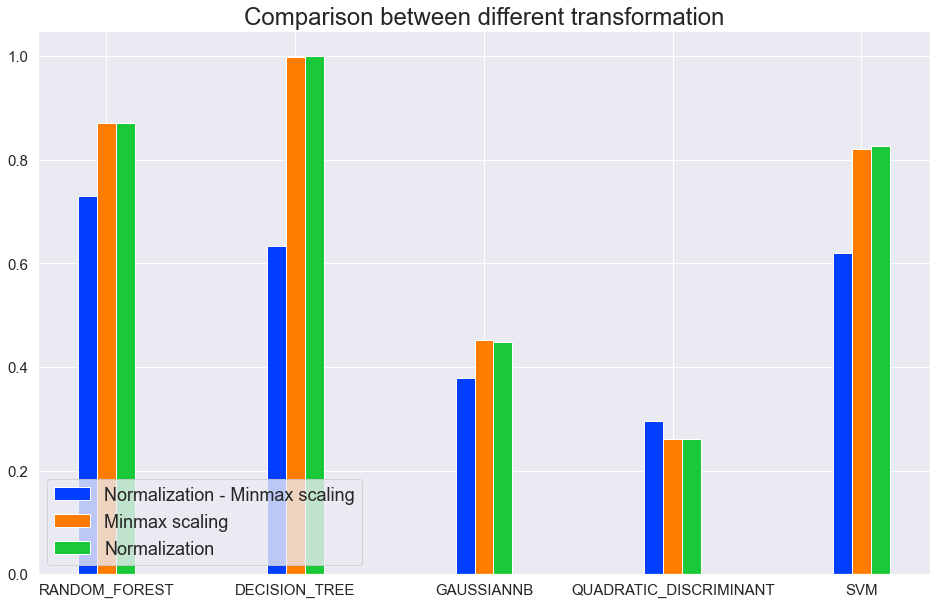

In [38]:
barplot_multiple_columns(groups=df['model_name'].unique(),elements_group=df['transformation'].unique(),data=data,title='Comparison between different transformation')